いつも楽しいコンペをありがとうございますー！   

簡単にtrain/test_log.csvについてとedaを行いました。  
train/testの比較観点ポイントまとめると  
- session_idの重複はない  
- 直帰率の差はない
- webページ遷移数の分布の差はほとんどない(連続した連続した同じ宿が出現する場合は一つの宿IDになっていることは注意)  
- 同sessionで同じ宿を2回以上見ているsessionは各々全体の3.5%ほどで差がない  
    - 調べている限りA->B->A->B... と2つの宿をいったりきたりのsessionしか見つけられてない(更に調査は必要)  

と結果的には差がないことを調査した形になってしまいました

In [160]:
import polars as pl
pl.Config.set_fmt_str_lengths(100)
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib_venn import venn2

from pathlib import Path
# data_dir
DATA_DIR = Path("~/GitHub/atma16_session_recommend/data/atmaCup16_Dataset")


## train/test_log

In [161]:
train_df = pl.read_csv(DATA_DIR / "train_log.csv")
test_df = pl.read_csv(DATA_DIR / "test_log.csv")

### 概要確認

In [166]:
# describeで概要確認
display("train概要", train_df.describe())
print("train_session_id unique数", train_df.select(pl.col("session_id").n_unique()).item())

display("test概要", test_df.describe())
print("test_session_id unique数", test_df.select(pl.col("session_id").n_unique()).item())


'train概要'

describe,session_id,seq_no,yad_no
str,str,f64,f64
"""count""","""419270""",419270.0,419270.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,0.397658,6879.812331
"""std""",null,0.684395,4018.859073
"""min""","""000007603d533d30453cc45d0f3d119f""",0.0,2.0
"""25%""",null,0.0,3338.0
"""50%""",null,0.0,6873.0
"""75%""",null,1.0,10350.0
"""max""","""fffffa7baf370083ebcdd98f26a7e31a""",9.0,13806.0


train_session_id unique数 288698


'test概要'

describe,session_id,seq_no,yad_no
str,str,f64,f64
"""count""","""250305""",250305.0,250305.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,0.379657,6859.588977
"""std""",null,0.661502,3982.391402
"""min""","""00001149e9c73985425197104712478c""",0.0,1.0
"""25%""",null,0.0,3361.0
"""50%""",null,0.0,6839.0
"""75%""",null,1.0,10305.0
"""max""","""ffffe984aafd6127ce8e43e3ca40c79d""",7.0,13806.0


test_session_id unique数 174700


両とも欠損無し  
データ数/session_id unique数共に testはtrainの60%ほど

### session_idの重複確認  

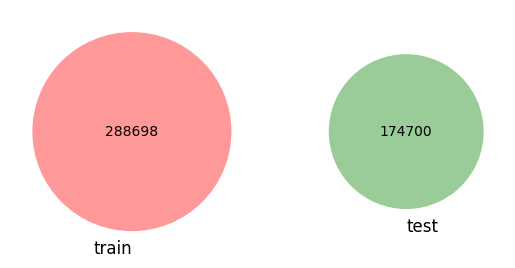

In [101]:
# train/testでsession_id重複はあるか
train_sessions = set(train_df.get_column("session_id"))
test_sessions = set(test_df.get_column("session_id"))

venn2(subsets=[train_sessions, test_sessions], set_labels=("train", "test"))
plt.show()

train/testで重複はないので純粋に行動履歴での検討が必要  

### 直帰率の確認  

In [102]:
# train/test_log内での直帰率(webページを1つだけ見て離脱したsessionの率)
train_session_count_df = (
    train_df
    .group_by("session_id")
    .agg(pl.count())
)

test_session_count_df = (
    test_df
    .group_by("session_id")
    .agg(pl.count())
)

print(
    "train直帰率:",
    (
        len(
            train_session_count_df
            .filter(pl.col("count")==1)
        )

        /

        len(train_df)
    )
)

print(
    "test直帰率:",
    (
        len(
            test_session_count_df
            .filter(pl.col("count")==1)
        )

        /

        len(test_df)
    )
)

train直帰率: 0.44216376082238174
test直帰率: 0.45520465032660157


直帰率は両とも約45%ほどで差がない  
このようなsessionたちへのレコメンドはデータが少ないので難しい  
一般的に人気の宿をおすすめするのが無難かもしれない  

### サイト遷移数の分布  

train_count_max: 10
test_count_max: 8


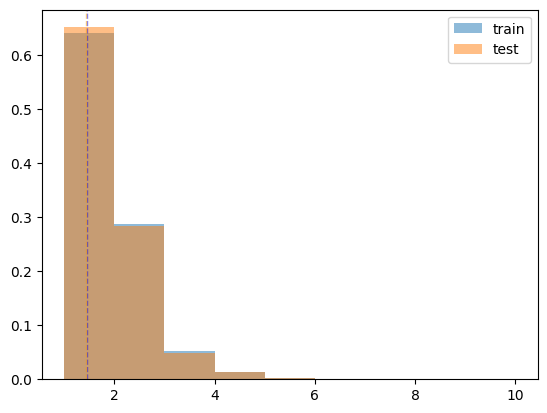

In [163]:
# サイト遷移数の分布
train_count_max = train_session_count_df.get_column("count").max()
train_count_min = train_session_count_df.get_column("count").min()
train_count_mean = train_session_count_df.get_column("count").mean()
print("train_count_max:", train_count_max)

test_count_max = test_session_count_df.get_column("count").max()
test_count_min = test_session_count_df.get_column("count").min()
test_count_mean = test_session_count_df.get_column("count").mean()
print("test_count_max:", test_count_max)

max_value = max(train_count_max, test_count_max)
min_value = min(train_count_min, test_count_min)

bins = np.linspace(min_value, max_value, 10)

plt.hist(train_session_count_df.select(pl.col("count")), bins=bins, label="train", alpha=0.5, density=True)
plt.axvline(train_count_mean, color='blue', linestyle='dashed', linewidth=1, alpha=0.5)

plt.hist(test_session_count_df.select(pl.col("count")), bins=bins, label="test", alpha=0.5, density=True)
plt.axvline(test_count_mean, color='orange', linestyle='dashed', linewidth=1, alpha=0.5)
plt.legend()
plt.show()

サイト遷移数の分布もtrain_test共に差がない  
平均は1.45くらい
trainデータセットの方が宿遷移数がmax10のセッションがある testデータセットでは8  
説明でもあったように、「連続した同じ宿が出現する場合、それらは一つの宿IDになっている」とのことなので  
同じ宿IDが連続する状況は  
宿概要 -> プラン一覧 -> プラン詳細...  
みたいな遷移のようなものだろうか "詳細まで見てるものはレコメンド対象"みたいなものができたら良さそうなのだがこのデータからはできなさそう

### 同じ宿を2回以上確認しているsession  

In [150]:
# A宿 -> B宿 -> A宿のように同じ宿を2回以上確認しているsessionはあるのか
train_duplicated_yad_no_df = (
    train_df
    .filter(
        pl.col("yad_no")
        .is_duplicated()
        .over("session_id")
    )
    .group_by(["session_id", "yad_no"])
    .agg(pl.count())
    .sort(["session_id", "count"], descending=True)
)

test_duplicated_yad_no_df = (
    test_df
    .filter(
        pl.col("yad_no")
        .is_duplicated()
        .over("session_id")
    )
    .group_by(["session_id", "yad_no"])
    .agg(pl.count())
    .sort(["session_id", "count"], descending=True)
)


display(
    "train",
    f"session_id unique数: {train_duplicated_yad_no_df.get_column('session_id').n_unique()}",
    "session/yad_no毎のカウント:",
    train_duplicated_yad_no_df
    ,
    "test",
    f"session_id unique数: {test_duplicated_yad_no_df.get_column('session_id').n_unique()}",
    "session/yad_no毎のカウント:",
    test_duplicated_yad_no_df
)

'train'

'session_id unique数: 15332'

'session/yad_no毎のカウント:'

session_id,yad_no,count
str,i64,u32
"""ffffcd5bc19d62cad5a3815c87818d83""",12230,2
"""fffc996274862c136b754a5d591a3bb3""",13292,2
"""fffc996274862c136b754a5d591a3bb3""",12785,2
"""fffa73278857a3cf46c16c207dbbcbd8""",1726,2
"""fff92e265c6b2b56fdbc0b89e18a34ab""",1636,2
"""fff92e265c6b2b56fdbc0b89e18a34ab""",1587,2
"""fff77fa4c36c982e2f7f58e924e11d52""",5444,2
"""fff77fa4c36c982e2f7f58e924e11d52""",3666,2
"""fff2bc8a171d57bfabf30d28ad889853""",13722,2


'test'

'session_id unique数: 8923'

'session/yad_no毎のカウント:'

session_id,yad_no,count
str,i64,u32
"""fff8c15d0ee42da2329958308d730a52""",5073,2
"""ffe6b66f8ccba0b7eb93d43c8e3f926b""",9654,2
"""ffe1c16740cb557b3e925f3992424249""",1170,2
"""ffd376208e4db52955bd37fe516fadfc""",13232,2
"""ffd2591b9e1c4ab30e2a60ba7c410756""",12408,2
"""ffca009ee13f16c6825ad024aebafed6""",7667,2
"""ffaf7522d90c4f3e3ba9eefcade49a38""",3812,2
"""ffa8a968027dada4afb61004cb34d1bf""",9380,2
"""ffa6ad836e9121246ec631d4d1b1dd30""",6659,2


同じ宿を2回以上調べているsession_idはtrain, testの約3.5%と差がない  
各々の代表データを確認する

In [133]:
display(
    "train",
    train_df
    .filter(pl.col("session_id")=="c2ba59a9eca4ff52f466793b7ce9a03a"),
    "test",
    test_df
    .filter(pl.col("session_id")=="beaf391cbaa4612ee9fcf533de745eaa"),
)

'train'

session_id,seq_no,yad_no
str,i64,i64
"""c2ba59a9eca4ff52f466793b7ce9a03a""",0,9308
"""c2ba59a9eca4ff52f466793b7ce9a03a""",1,5252
"""c2ba59a9eca4ff52f466793b7ce9a03a""",2,9308
"""c2ba59a9eca4ff52f466793b7ce9a03a""",3,5252
"""c2ba59a9eca4ff52f466793b7ce9a03a""",4,9308
"""c2ba59a9eca4ff52f466793b7ce9a03a""",5,5252
"""c2ba59a9eca4ff52f466793b7ce9a03a""",6,9308
"""c2ba59a9eca4ff52f466793b7ce9a03a""",7,5252
"""c2ba59a9eca4ff52f466793b7ce9a03a""",8,9308


'test'

session_id,seq_no,yad_no
str,i64,i64
"""beaf391cbaa4612ee9fcf533de745eaa""",0,719
"""beaf391cbaa4612ee9fcf533de745eaa""",1,2797
"""beaf391cbaa4612ee9fcf533de745eaa""",2,719
"""beaf391cbaa4612ee9fcf533de745eaa""",3,2797
"""beaf391cbaa4612ee9fcf533de745eaa""",4,719
"""beaf391cbaa4612ee9fcf533de745eaa""",5,2797
"""beaf391cbaa4612ee9fcf533de745eaa""",6,719
"""beaf391cbaa4612ee9fcf533de745eaa""",7,2797


いったりきたりパターン  
この人は既に2つに絞って考えられてる  
セッション内で最後に出現する宿は必ず正解ラベルと異なるので、もう一つのyad_noが有力候補になる  
</br>
ざっと見たかぎりこのパターンしか見つけれられていない(他のパターンもありそうなのでもっと調査が必要です)  